# **Build A Basic Chatbot With Langgraph(GRAPH API)**

## **1. Build Simple Chat bot**

### 1. Install and Import

In [1]:
# !uv pip install typing_extensions
# !uv pip install langgraph
# !uv pip install langchain_tavily
# !uv pip install langchain-groq
# !uv pip install langsmith
# !uv pip install python-dotenv


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [3]:
import os
from dotenv import load_dotenv
load_dotenv('token.env')  # path to your token.env file

langchain_api_key = os.getenv("langchain_api_key")
openai_api_keys = os.getenv("openai_api_key")
tavily_api_key = os.getenv("tavily_api_key")
groq_api_key = os.getenv("groq_api_key")
print("Langchain Key:      ",langchain_api_key[:5] + "..." if langchain_api_key else "key not found")
print("openai_api_key Key: ",openai_api_keys[:5] + "..." if openai_api_keys else "key not found")
print("tavily_api_key Key: ",tavily_api_key[:5] + "..." if tavily_api_key else "key not found")
print("groq_api_key Key:   ",groq_api_key[:5] + "..." if groq_api_key else "key not found")


Langchain Key:       lsv2_...
openai_api_key Key:  sk-pr...
tavily_api_key Key:  tvly-...
groq_api_key Key:    gsk_J...


In [4]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

### 2. Add State

In [5]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]


### 3. Define LLM and Initiliaze

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model


llm=ChatGroq(model="llama3-8b-8192")

llm=init_chat_model("groq:llama3-8b-8192")
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000019897195310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000019897195D10>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

### 4. Chatbot

In [7]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

### 5. Define Node 

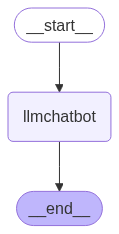

In [8]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)

## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()
graph

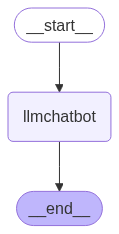

In [9]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
from pprint import pprint
response=graph.invoke({"messages":"Hi"})
pprint(response["messages"])

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='4663d253-7009-4387-a796-075118e5a6c0'),
 AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.020514469, 'prompt_time': 0.001828671, 'queue_time': 0.221711188, 'total_time': 0.02234314}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--e03e8f9c-bdec-468a-a816-e7db04f48c8a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})]


In [11]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [12]:
for event in graph.stream({"messages":"Hi How are you?"}):
    print(event)

{'llmchatbot': {'messages': [AIMessage(content="Hi! I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 15, 'total_tokens': 62, 'completion_time': 0.037241309, 'prompt_time': 0.002955371, 'queue_time': 0.221349633, 'total_time': 0.04019668}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'stop', 'logprobs': None}, id='run--c2e758ff-a25b-4129-bb75-68087a805c6e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 47, 'total_tokens': 62})]}}


In [13]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm just an AI, I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or topics you'd like to discuss! How about you? How's your day going?


### 6. Chatbot With Tool

In [14]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'What Is LangGraph and How to Use It? - DataCamp',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactions.',
   '

In [15]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b



def my_info():
    """
    If some one ask my name than tell my name
    Return my info
    
    """
    return "I am a Zain chatbot created by Langgraph"



# tools=[tool , multiply , my_info]
tools=[tool , multiply]
llm_with_tool = llm.bind_tools(tools)
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000019897195310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000019897195D10>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

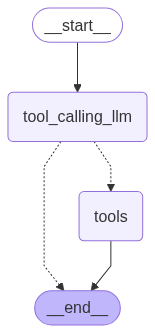

In [16]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


## Grpah
builder = StateGraph(State)

# Add nodes
builder.add_node("tool_calling_llm" , tool_calling_llm)
builder.add_node("tools" , ToolNode(tools))


## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


## compile the graph
graph = builder.compile()
graph

# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
question = "What is recent AI news?"
# question = "Who is the president of USA?"
response=graph.invoke({"messages":question})
response

{'messages': [HumanMessage(content='What is recent AI news?', additional_kwargs={}, response_metadata={}, id='7603d6a4-519d-44fa-8f3b-b77282795d10'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '21yecakcz', 'function': {'arguments': '{"a":null,"b":null,"exclude_domains":[],"include_domains":[],"include_images":true,"query":"recent AI news","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 2194, 'total_tokens': 2318, 'completion_time': 0.098354817, 'prompt_time': 0.242717628, 'queue_time': 0.22365103100000003, 'total_time': 0.341072445}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4543bacf-61ef-4f45-acb5-eff01bd81778-0', tool_calls=[{'name': 'tavily_search', 'args': {'a': None, 'b': None, 'exclude_domains': [], 'include_domains': [], 'includ

In [18]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": ["https://datasciencedojo.com/wp-content/uploads/emerging-AI-and-machine-learning-trends.png", "https://moonpreneur.com/blog/wp-content/uploads/2023/03/5-latest-developments-in-ai.png", "https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://www.managedoutsource.com/wp-content/uploads/2020/04/top-artificial-intelligence-ai-trends-to-watch-for-in-2020.jpg", "https://i.ytimg.com/vi/DRJeOrfFlh0/maxresdefault.jpg"], "results": [{"url": "https://www.ptechpartners.com/2025/07/01/emerging-ai-news-roundup-for-may-and-june-2025-part-1-ai-agents-jobs-impact-and-the-return-of-the-surge/", "title": "Emerging AI News Roundup for May and June 2025 Part 1", "content": "Explore the biggest AI news from May and June 2025, including breakthroughs in AI agents, the evolving impact on jobs, and a renewed surge in AI 

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (21yecakcz)
 Call ID: 21yecakcz
  Args:
    a: None
    b: None
    exclude_domains: []
    include_domains: []
    include_images: True
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": ["https://datasciencedojo.com/wp-content/uploads/emerging-AI-and-machine-learning-trends.png", "https://moonpreneur.com/blog/wp-content/uploads/2023/03/5-latest-developments-in-ai.png", "https://autogpt.net/wp-content/uploads/2023/07/Pogla_Explore_the_latest_AI_news_from_groundbreaking_drug_trial_07ab875d-1e11-42d5-89ef-39ff3d5ab451.jpg", "https://www.managedoutsource.

In [20]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (peegdstfg)
 Call ID: peegdstfg
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [21]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (2n1tqvqcv)
 Call ID: 2n1tqvqcv
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/07/01/xai-raises-10b-in-debt-and-equity/", "title": "xAI raises $10B in debt and equity - TechCrunch", "score": 0.7123327, "published_date": "Tue, 01 Jul 2025 12:35:54 GMT", "content": "Sean O'Kane\n\n 4 days ago\n\n   \nImage 8: Tesla illustration logo\n\nTransportation \n### Elon Musk reportedly fires Tesla’s top sales exec\n\n       Sean O'Kane\n\n Jun 26, 2025\n\nLatest in AI\n-----

## 2. ReAct Agent Architecture

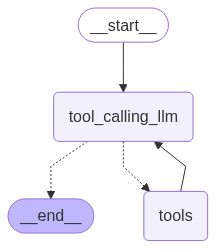

In [22]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


## Grpah
builder=StateGraph(State)


# Add nodes
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")


## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kbrhxye1n)
 Call ID: kbrhxye1n
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
  multiply (05azka49z)
 Call ID: 05azka49z
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7318455, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from Ju

## **2. Adding Memory In Agentic Graph**

In [24]:
response=graph.invoke({"messages":"Hello my name is KRish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is KRish
================================== Ai Message ==================================

Nice to meet you, KRish!


In [25]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I apologize, but I don't have any information about your name.


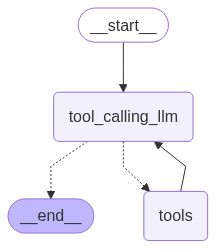

In [26]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


## Grpah
builder=StateGraph(State)


# Add nodes
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")


## compile the graph
graph=builder.compile(checkpointer=memory)


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"Hi my name is Krish"},config=config)
response


{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='f50f8ed8-5318-42a7-9dd0-a1cc60f523d6'),
  AIMessage(content='Nice to meet you, Krish! What brings you here today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 2193, 'total_tokens': 2207, 'completion_time': 0.011282157, 'prompt_time': 0.241798525, 'queue_time': 0.22351951600000003, 'total_time': 0.253080682}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--e48cddcf-deaa-4877-953e-e6ecb8780b2d-0', usage_metadata={'input_tokens': 2193, 'output_tokens': 14, 'total_tokens': 2207})]}

In [28]:
response['messages'][-1].content

'Nice to meet you, Krish! What brings you here today?'

In [29]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Krish!


In [30]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

I remember, your name is Krish!


### 1. Create Simple Agent

In [31]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [32]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

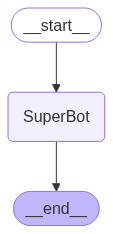

In [33]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)

## Edges
graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [34]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='cfe21f70-f98b-415c-90e2-5afaf4cc9893'),
  AIMessage(content="Nice to meet you, Krish! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 20, 'total_tokens': 47, 'completion_time': 0.092904154, 'prompt_time': 0.013555155, 'queue_time': 0.265683815, 'total_time': 0.106459309}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--043ad96e-8d14-47c3-b3e3-0ee1cd556358-0', usage_metadata={'input_tokens': 20, 'output_tokens': 27, 'total_tokens': 47})]}

### 2. Streaming 

Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [38]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    pprint(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Krish! It's great to meet you! I see you mentioned you like cricket again! That's awesome! I'm excited to chat with you about cricket. Do you have a favorite team or player? Have you played cricket yourself or just enjoy watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 155, 'total_tokens': 209, 'completion_time': 0.043366587, 'prompt_time': 0.031334399, 'queue_time': 0.221635401, 'total_time': 0.074700986}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--63d1bb28-ce73-4b4a-8415-7f4c811800a7-0', usage_metadata={'input_tokens': 155, 'output_tokens': 54, 'total_tokens': 209})]}}


In [36]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='9d5fd8d4-238f-4ae5-8590-bb7b73056bba'), AIMessage(content='Hi Krish! Nice to meet you! So, you like cricket, huh? Which team do you support? Are you a fan of any particular player or tournament?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 20, 'total_tokens': 54, 'completion_time': 0.150412591, 'prompt_time': 0.016483555, 'queue_time': 0.26603323300000004, 'total_time': 0.166896146}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--41324e3a-17ed-4665-865a-b296786dbcdd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 34, 'total_tokens': 54}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='12c5560b-00d5-4acd-af03-53dbe5e43644')]}
{'messages': [HumanMessage(content='

In [37]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Krish! Nice to meet you! Cricket is a great sport, isn't it? Who's your favorite team or player? Do you play cricket yourself or just enjoy watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 20, 'total_tokens': 58, 'completion_time': 0.051246356, 'prompt_time': 0.004681773, 'queue_time': 0.272316476, 'total_time': 0.055928129}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'stop', 'logprobs': None}, id='run--5212dc88-b6d6-49f0-a9c1-2fb14321fccd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 38, 'total_tokens': 58})]}}


In [39]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='9d5fd8d4-238f-4ae5-8590-bb7b73056bba'), AIMessage(content='Hi Krish! Nice to meet you! So, you like cricket, huh? Which team do you support? Are you a fan of any particular player or tournament?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 20, 'total_tokens': 54, 'completion_time': 0.150412591, 'prompt_time': 0.016483555, 'queue_time': 0.26603323300000004, 'total_time': 0.166896146}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--41324e3a-17ed-4665-865a-b296786dbcdd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 34, 'total_tokens': 54}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='12c5560b-00d5-4acd-af03-53dbe5e43644'), AIMessage(content="Hi Krish! Nice to 

In [40]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '16658c30-d9f6-4489-ab5c-e16be987ca37', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='70e90418-5ef9-4759-91c6-2f6e1732d63f')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '5bb18e61-3a1d-4056-9a7f-f9850b1a5ee8', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:eaa28876-ecf1-051e-52c6-7b5f2efa6790'}, 'parent_ids': ['16658c30-d9f6-4489-ab5c-e16be987ca37']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla